In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/27919209.zip"

Archive:  /content/drive/My Drive/27919209.zip
 extracting: MSLesSeg Dataset.zip    
 extracting: MSLesSeg_RAW.zip        
 extracting: MSLesSeg-2024-main.zip  
 extracting: mat_files.zip           
 extracting: README.md               


In [ ]:
!unzip "MSLesSeg Dataset.zip"

Archive:  MSLesSeg Dataset.zip
   creating: MSLesSeg Dataset/
   creating: MSLesSeg Dataset/info_dataset/
  inflating: MSLesSeg Dataset/info_dataset/clinical_data.csv  
   creating: MSLesSeg Dataset/info_dataset/patient_scanners_info/
  inflating: MSLesSeg Dataset/info_dataset/patient_scanners_info/patient_scanners_info_FLAIR.csv  
  inflating: MSLesSeg Dataset/info_dataset/patient_scanners_info/patient_scanners_info_T1.csv  
  inflating: MSLesSeg Dataset/info_dataset/patient_scanners_info/patient_scanners_info_T2.csv  
   creating: MSLesSeg Dataset/test/
   creating: MSLesSeg Dataset/test/P54/
  inflating: MSLesSeg Dataset/test/P54/P54_FLAIR.nii.gz  
  inflating: MSLesSeg Dataset/test/P54/P54_MASK.nii.gz  
  inflating: MSLesSeg Dataset/test/P54/P54_T1.nii.gz  
  inflating: MSLesSeg Dataset/test/P54/P54_T2.nii.gz  
   creating: MSLesSeg Dataset/test/P55/
  inflating: MSLesSeg Dataset/test/P55/P55_FLAIR.nii.gz  
  inflating: MSLesSeg Dataset/test/P55/P55_MASK.nii.gz  
  inflating: MSLes

In [ ]:
!pip install nibabel matplotlib

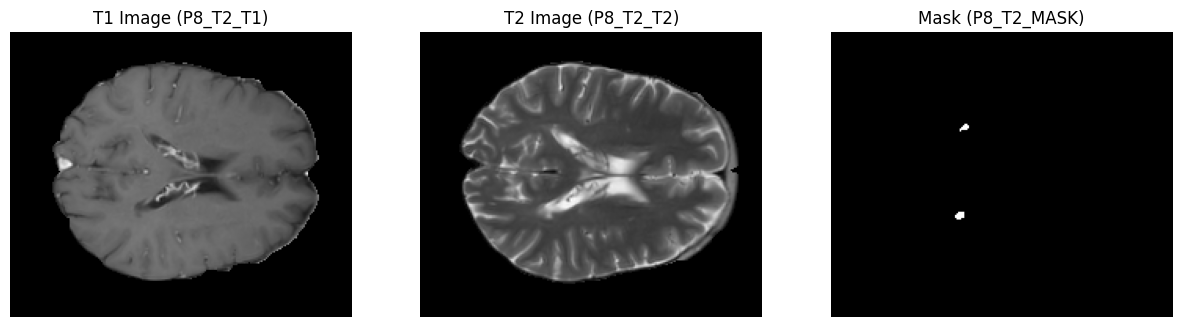

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

mask_path = "/content/MSLesSeg Dataset/train/P8/T2/P8_T2_MASK.nii.gz"
t1_path   = "/content/MSLesSeg Dataset/train/P8/T2/P8_T2_T1.nii.gz"
t2_path   = "/content/MSLesSeg Dataset/train/P8/T2/P8_T2_T2.nii.gz"

mask_img = nib.load(mask_path)
t1_img   = nib.load(t1_path)
t2_img   = nib.load(t2_path)

mask_data = mask_img.get_fdata()
t1_data   = t1_img.get_fdata()
t2_data   = t2_img.get_fdata()

slice_idx = mask_data.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(t1_data[:, :, slice_idx], cmap='gray')
axes[0].set_title('T1 Image (P8_T2_T1)')
axes[1].imshow(t2_data[:, :, slice_idx], cmap='gray')
axes[1].set_title('T2 Image (P8_T2_T2)')
axes[2].imshow(mask_data[:, :, slice_idx], cmap='gray')
axes[2].set_title('Mask (P8_T2_MASK)')
for ax in axes:
    ax.axis('off')
plt.show()

In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from scipy.spatial import ConvexHull
from tqdm.auto import tqdm

In [ ]:
def analyze_mask(mask_path):
    """
    Analyze one NIfTI mask file:
    - Count lesions
    - Get bounding circle (center, radius)
    - Compute area/volume stats
    """
    img = nib.load(mask_path)
    data = img.get_fdata()

    mask = (data > 0).astype(np.uint8)

    labeled = label(mask, connectivity=1)
    regions = regionprops(labeled)

    lesion_stats = []

    for region in regions:
        coords = region.coords
        z, y, x = coords[:,0], coords[:,1], coords[:,2]

        centroid = np.mean(coords, axis=0)

        distances = np.linalg.norm(coords - centroid, axis=1)
        radius = np.max(distances)

        lesion_stats.append({
            "lesion_id": region.label,
            "volume_voxels": len(coords),
            "centroid_z": centroid[0],
            "centroid_y": centroid[1],
            "centroid_x": centroid[2],
            "bounding_radius": radius
        })

    return lesion_stats


In [ ]:
def count_files_recursive(directory_path):
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

In [ ]:
# count_files_recursive(mask_dir) / 4

In [ ]:
mask_dir = "/content/MSLesSeg Dataset/train"
all_stats = []

for root, dirs, files in tqdm(os.walk(mask_dir), total=93):
    for file in files:
        if file.endswith("_MASK.nii.gz"):
            mask_path = os.path.join(root, file)
            patient_id = root.split("/")[-2]
            seq = root.split("/")[-1]

            lesion_data = analyze_mask(mask_path)
            for lesion in lesion_data:
                lesion["patient"] = patient_id
                lesion["sequence"] = seq
                lesion["file"] = file
                all_stats.append(lesion)

df = pd.DataFrame(all_stats)
df.head()


  0%|          | 0/93 [00:00<?, ?it/s]

,lesion_id,volume_voxels,centroid_z,centroid_y,centroid_x,bounding_radius,patient,sequence,file
0,1,78,35.307692,130.051282,103.205128,3.228224,P38,T1,P38_T1_MASK.nii.gz
1,2,54,37.925926,124.166667,90.574074,3.583896,P38,T1,P38_T1_MASK.nii.gz
2,3,51,38.882353,114.333333,91.137255,3.138419,P38,T1,P38_T1_MASK.nii.gz
3,4,56,40.142857,125.857143,47.017857,5.858912,P38,T1,P38_T1_MASK.nii.gz
4,5,28,40.357143,88.964286,108.142857,2.001594,P38,T1,P38_T1_MASK.nii.gz


In [ ]:
df[df['patient']=='P39']

,lesion_id,volume_voxels,centroid_z,centroid_y,centroid_x,bounding_radius,patient,sequence,file
393,1,41,31.487805,127.536585,91.756098,2.383889,P39,T1,P39_T1_MASK.nii.gz
394,2,431,42.631090,127.709977,84.067285,7.821065,P39,T1,P39_T1_MASK.nii.gz
395,3,312,42.602564,124.676282,113.365385,7.420439,P39,T1,P39_T1_MASK.nii.gz
396,4,67904,94.441299,106.275271,90.267584,68.328623,P39,T1,P39_T1_MASK.nii.gz
397,5,88,48.215909,69.238636,111.181818,4.008546,P39,T1,P39_T1_MASK.nii.gz
398,6,276,52.692029,100.532609,107.163043,5.911119,P39,T1,P39_T1_MASK.nii.gz
399,7,142,52.478873,168.845070,91.957746,4.202804,P39,T1,P39_T1_MASK.nii.gz
400,8,1,52.000000,95.000000,69.000000,0.000000,P39,T1,P39_T1_MASK.nii.gz
401,9,2,56.500000,101.000000,112.000000,0.500000,P39,T1,P39_T1_MASK.nii.gz
402,10,25,59.640000,117.920000,98.520000,2.174029,P39,T1,P39_T1_MASK.nii.gz


In [ ]:
df_filtered = df[df['volume_voxels'] <= 1000]

Total lesions detected: 2688
Patients analyzed: 53

Lesion volume (voxels):
count     2688.000000
mean       420.965774
std       2323.723805
min          1.000000
25%         30.000000
50%         64.000000
75%        147.000000
max      67904.000000
Name: volume_voxels, dtype: float64


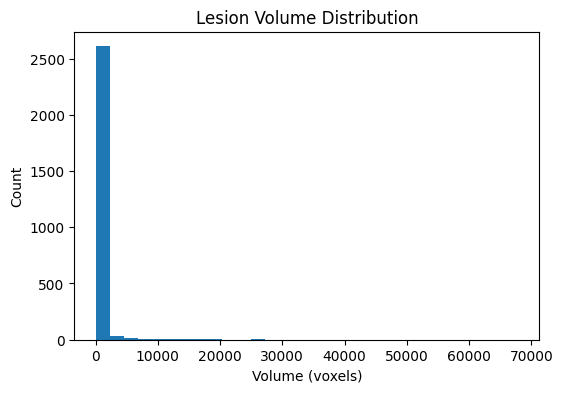

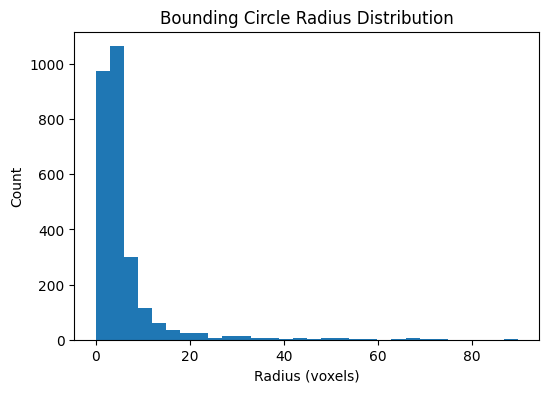

In [ ]:
print(f"Total lesions detected: {len(df)}")
print(f"Patients analyzed: {df['patient'].nunique()}")

print("\nLesion volume (voxels):")
print(df['volume_voxels'].describe())

plt.figure(figsize=(6,4))
plt.hist(df['volume_voxels'], bins=30)
plt.title('Lesion Volume Distribution')
plt.xlabel('Volume (voxels)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['bounding_radius'], bins=30)
plt.title('Bounding Circle Radius Distribution')
plt.xlabel('Radius (voxels)')
plt.ylabel('Count')
plt.show()

Total lesions detected: 2550
Patients analyzed: 53

Lesion volume (voxels):
count    2550.000000
mean      111.738039
std       153.770849
min         1.000000
25%        28.000000
50%        59.000000
75%       123.000000
max       999.000000
Name: volume_voxels, dtype: float64


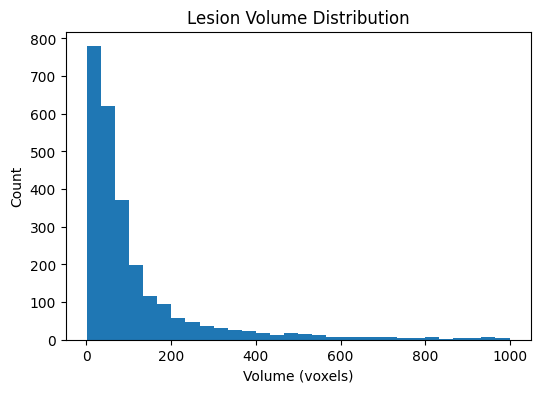

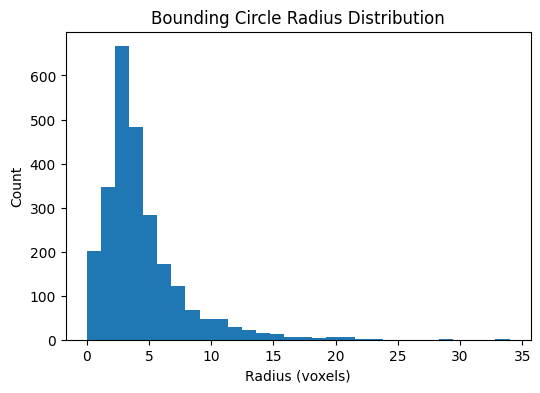

In [ ]:
print(f"Total lesions detected: {len(df_filtered)}")
print(f"Patients analyzed: {df_filtered['patient'].nunique()}")

print("\nLesion volume (voxels):")
print(df_filtered['volume_voxels'].describe())

plt.figure(figsize=(6,4))
plt.hist(df_filtered['volume_voxels'], bins=30)
plt.title('Lesion Volume Distribution')
plt.xlabel('Volume (voxels)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_filtered['bounding_radius'], bins=30)
plt.title('Bounding Circle Radius Distribution')
plt.xlabel('Radius (voxels)')
plt.ylabel('Count')
plt.show()

In [ ]:
cnt_per_pat = df.groupby('patient').count()['lesion_id']

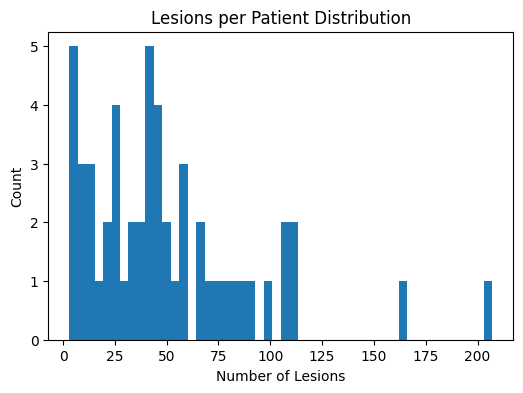

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(cnt_per_pat, bins=50)
plt.title('Lesions per Patient Distribution')
plt.xlabel('Number of Lesions')
plt.ylabel('Count')
plt.show()

In [ ]:
df['volume_voxels'].quantile(0.95)

np.float64(1035.7500000000014)

In [ ]:
largest_lesion = df.loc[df['volume_voxels'].idxmax()]
largest_lesion

,2535
lesion_id,4
volume_voxels,67904
centroid_z,94.441299
centroid_y,106.275271
centroid_x,90.267584
bounding_radius,68.328623
patient,P39
sequence,T1
file,P39_T1_MASK.nii.gz


In [ ]:
mask_path = os.path.join(mask_dir, largest_lesion["patient"], largest_lesion["sequence"], largest_lesion["file"])
print("Mask file:", mask_path)
print("Lesion volume (voxels):", largest_lesion["volume_voxels"])

Mask file: /content/MSLesSeg Dataset/train/P39/T1/P39_T1_MASK.nii.gz
Lesion volume (voxels): 67904


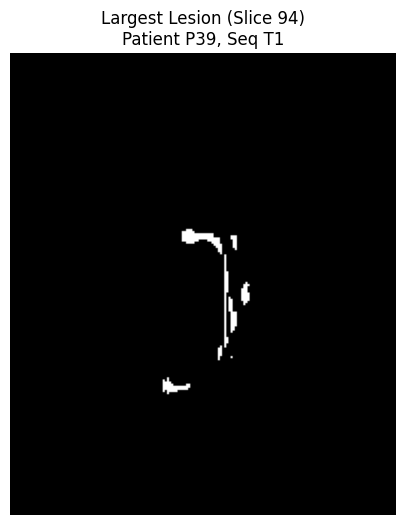

In [ ]:
mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata()

labeled = label(mask_data > 0)
regions = regionprops(labeled)

largest_region = max(regions, key=lambda r: len(r.coords))

coords = largest_region.coords
z, y, x = coords[:,0], coords[:,1], coords[:,2]
centroid = np.mean(coords, axis=0)
z_slice = int(centroid[0])

slice_mask = mask_data[z_slice,:,:]

plt.figure(figsize=(6,6))
plt.imshow(slice_mask, cmap='gray')
plt.title(f"Largest Lesion (Slice {z_slice})\nPatient {largest_lesion['patient']}, Seq {largest_lesion['sequence']}")
plt.axis('off')
plt.show()

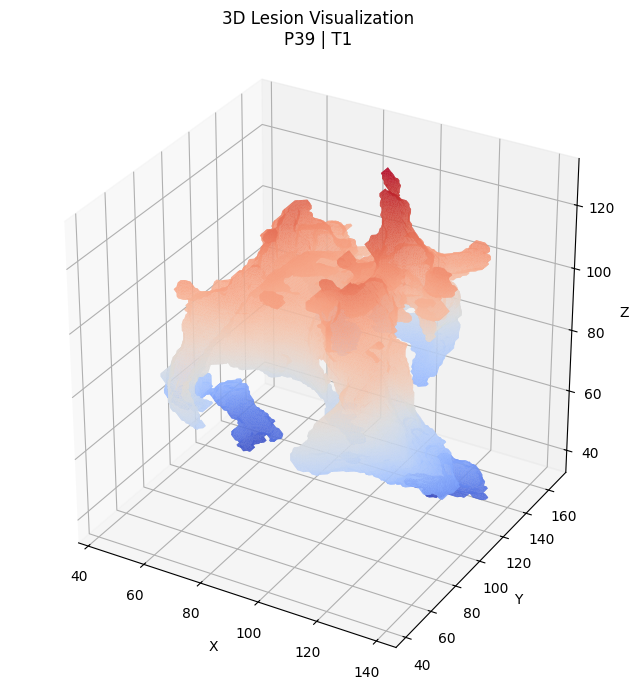

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, marching_cubes

mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata()

labeled = label(mask_data > 0)
regions = regionprops(labeled)

largest_region = max(regions, key=lambda r: len(r.coords))
coords = largest_region.coords

lesion_mask = np.zeros_like(mask_data)
lesion_mask[tuple(coords.T)] = 1

verts, faces, normals, values = marching_cubes(lesion_mask, level=0.5)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(
    verts[:, 0], verts[:, 1], faces, verts[:, 2],
    cmap='coolwarm', lw=0.3, alpha=0.8
)

ax.set_title(f"3D Lesion Visualization\n{largest_lesion['patient']} | {largest_lesion['sequence']}")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_box_aspect([1, 1, 1])

plt.show()


In [ ]:
import nibabel as nib
import numpy as np
from skimage.measure import label, regionprops

mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata()

labeled = label(mask_data > 0)
regions = regionprops(labeled)
largest_region = max(regions, key=lambda r: len(r.coords))
coords = largest_region.coords

lesion_mask = np.zeros_like(mask_data)
lesion_mask[tuple(coords.T)] = 1

mri_path = mask_path.replace("_MASK.nii.gz", "_T2.nii.gz")
if not os.path.exists(mri_path):
    mri_path = mask_path.replace("_MASK.nii.gz", "_T1.nii.gz")

print("MRI path:", mri_path)

mri_img = nib.load(mri_path)
mri_data = mri_img.get_fdata()


MRI path: /content/MSLesSeg Dataset/train/P39/T1/P39_T1_T2.nii.gz


In [ ]:
mri_data_norm = (mri_data - np.min(mri_data)) / (np.max(mri_data) - np.min(mri_data))


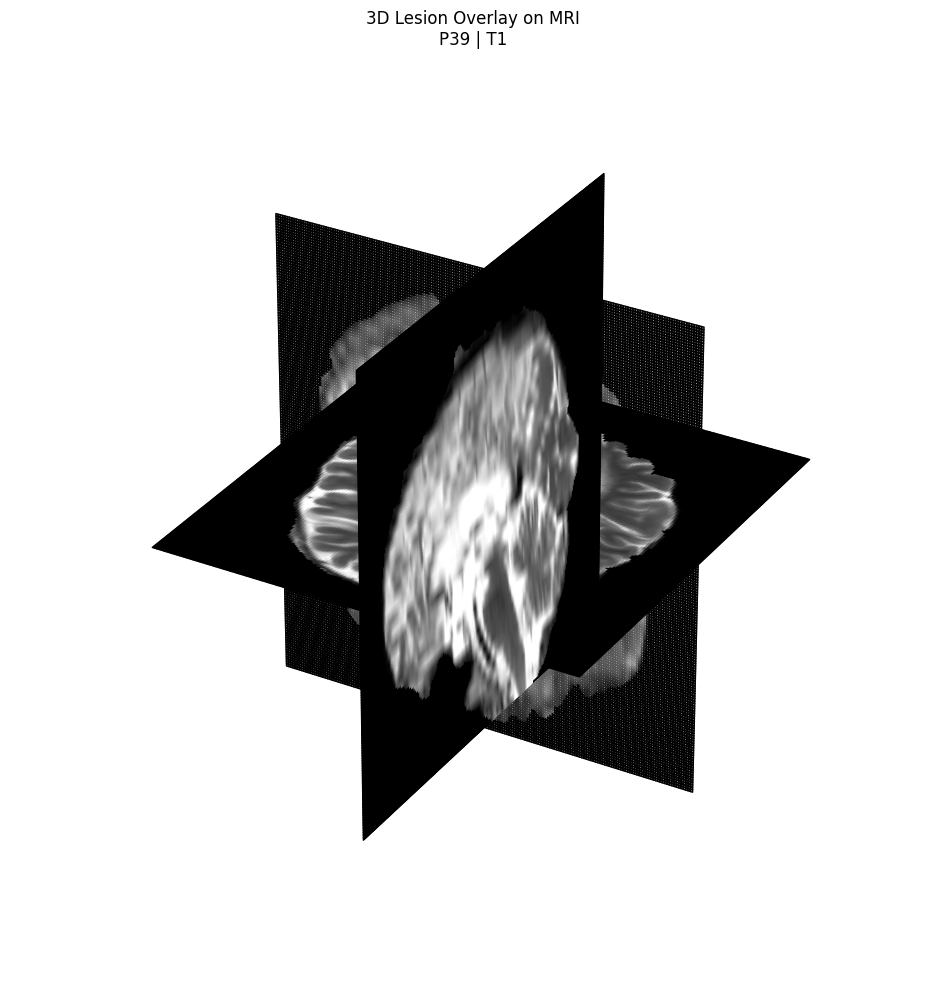

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import label, regionprops, marching_cubes
import os

mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata()

labeled = label(mask_data > 0)
regions = regionprops(labeled)
largest_region = max(regions, key=lambda r: len(r.coords))
coords = largest_region.coords

lesion_mask = np.zeros_like(mask_data)
lesion_mask[tuple(coords.T)] = 1

mri_path = mask_path.replace("_MASK.nii.gz", "_T2.nii.gz")
if not os.path.exists(mri_path):
    mri_path = mask_path.replace("_MASK.nii.gz", "_T1.nii.gz")

mri_img = nib.load(mri_path)
mri_data = mri_img.get_fdata()
mri_data = np.nan_to_num(mri_data)

mri_norm = (mri_data - np.percentile(mri_data, 1)) / (np.percentile(mri_data, 99) - np.percentile(mri_data, 1))
mri_norm = np.clip(mri_norm, 0, 1)

verts, faces, normals, values = marching_cubes(lesion_mask, level=0.5)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x_mid = mri_norm.shape[0] // 2
y_mid = mri_norm.shape[1] // 2
z_mid = mri_norm.shape[2] // 2

X, Y = np.meshgrid(np.arange(mri_norm.shape[0]), np.arange(mri_norm.shape[1]))
Z = np.full_like(X, z_mid)
ax.plot_surface(X, Y, Z, facecolors=plt.cm.gray(mri_norm[:, :, z_mid].T), rstride=1, cstride=1, shade=False, alpha=0.4)

X, Z = np.meshgrid(np.arange(mri_norm.shape[0]), np.arange(mri_norm.shape[2]))
Y = np.full_like(X, y_mid)
ax.plot_surface(X, Y, Z, facecolors=plt.cm.gray(mri_norm[:, y_mid, :].T), rstride=1, cstride=1, shade=False, alpha=0.4)

Y, Z = np.meshgrid(np.arange(mri_norm.shape[1]), np.arange(mri_norm.shape[2]))
X = np.full_like(Y, x_mid)
ax.plot_surface(X, Y, Z, facecolors=plt.cm.gray(mri_norm[x_mid, :, :].T), rstride=1, cstride=1, shade=False, alpha=0.4)

ax.plot_trisurf(
    verts[:, 0], verts[:, 1], faces, verts[:, 2],
    color='red', lw=0.1, alpha=0.7, shade=True
)

ax.set_box_aspect([1, 1, 1])
ax.view_init(30, 120)
ax.set_title(f"3D Lesion Overlay on MRI\n{largest_lesion['patient']} | {largest_lesion['sequence']}")
ax.set_axis_off()

plt.tight_layout()
plt.show()


In [ ]:
import os
import nibabel as nib
import numpy as np
from skimage.measure import label, regionprops
from tqdm.auto import tqdm

mask_dir = "/content/MSLesSeg Dataset/train"
mri_suffix = "_T2.nii.gz"
mask_suffix = "_MASK.nii.gz"
patch_size = (32, 64, 64)
small_lesion_thresh = 28
output_dir = "/content/patches"

os.makedirs(output_dir, exist_ok=True)

def crop_patch(volume, center, size):
    """Вырезает кубический патч из 3D объема."""
    zc, yc, xc = np.round(center).astype(int)
    sz, sy, sx = np.array(size) // 2
    z1, y1, x1 = np.maximum([zc-sz, yc-sy, xc-sx], 0)
    z2, y2, x2 = np.minimum([zc+sz, yc+sy, xc+sx], volume.shape)
    patch = np.zeros(size, dtype=volume.dtype)
    patch_slice = volume[z1:z2, y1:y2, x1:x2]
    patch[:patch_slice.shape[0], :patch_slice.shape[1], :patch_slice.shape[2]] = patch_slice
    return patch

def extract_patches(mri_path, mask_path, save_dir):
    img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    mri = img.get_fdata()
    mask = (mask_img.get_fdata() > 0).astype(np.uint8)

    labeled = label(mask, connectivity=1)
    regions = regionprops(labeled)

    for region in regions:
        if region.area <= small_lesion_thresh:
            centroid = region.centroid
            lesion_id = region.label

            clean_mask = np.zeros_like(mask)
            clean_mask[labeled == lesion_id] = 1

            mri_patch = crop_patch(mri, centroid, patch_size)
            mask_patch = crop_patch(clean_mask, centroid, patch_size)

            base_name = os.path.basename(mask_path).replace(mask_suffix, f"_lesion{lesion_id}")
            mri_out = os.path.join(save_dir, base_name + "_MRI.nii.gz")
            mask_out = os.path.join(save_dir, base_name + "_MASK.nii.gz")

            nib.save(nib.Nifti1Image(mri_patch, img.affine), mri_out)
            nib.save(nib.Nifti1Image(mask_patch, mask_img.affine), mask_out)

def process_dataset(mask_dir, output_dir):
    for root, dirs, files in tqdm(os.walk(mask_dir)):
        for file in files:
            if file.endswith(mask_suffix):
                mask_path = os.path.join(root, file)
                mri_path = mask_path.replace(mask_suffix, mri_suffix)
                if not os.path.exists(mri_path):
                    continue
                patient_dir = os.path.join(output_dir, os.path.basename(root))
                os.makedirs(patient_dir, exist_ok=True)
                extract_patches(mri_path, mask_path, patient_dir)

process_dataset(mask_dir, output_dir)


0it [00:00, ?it/s]

Found 648 mask patches.


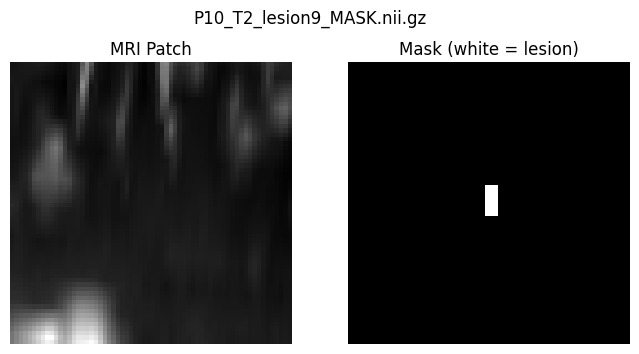

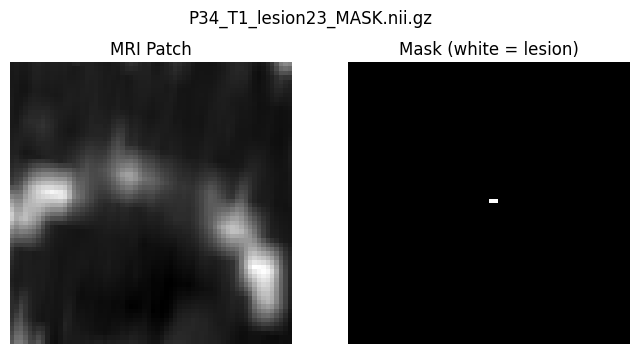

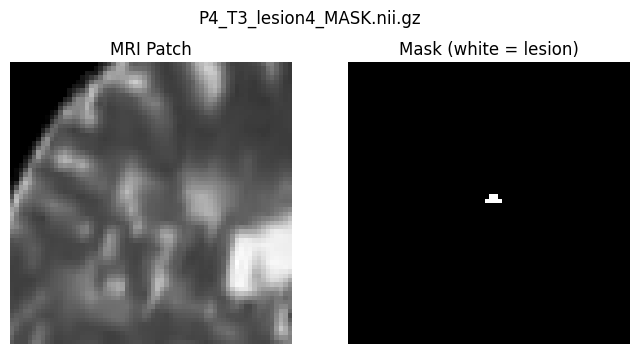

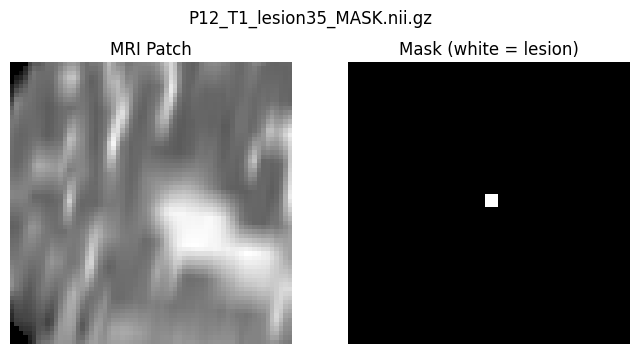

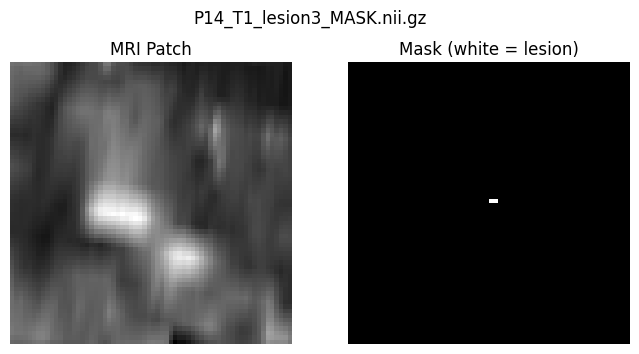

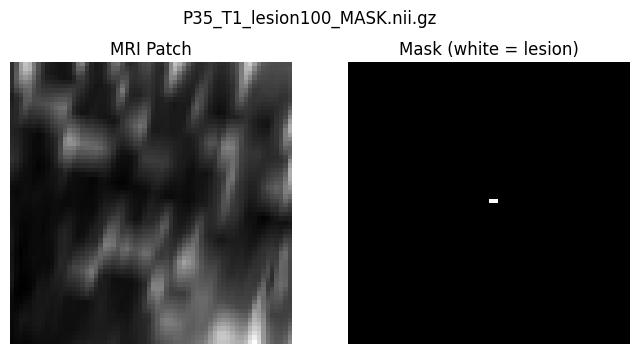

In [ ]:
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

patch_dir = "/content/patches"

mask_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(patch_dir)
              for f in filenames if f.endswith("_MASK.nii.gz")]

print(f"Found {len(mask_files)} mask patches.")

sample_files = random.sample(mask_files, min(6, len(mask_files)))

for mask_path in sample_files:
    mri_path = mask_path.replace("_MASK.nii.gz", "_MRI.nii.gz")
    mask = nib.load(mask_path).get_fdata()
    mri = nib.load(mri_path).get_fdata()

    mri = (mri - np.min(mri)) / (np.max(mri) - np.min(mri) + 1e-5)

    z_mid = mri.shape[0] // 2

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(mri[z_mid,:,:].T, cmap="gray", origin="lower")
    plt.title("MRI Patch")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask[z_mid,:,:].T, cmap="gray", origin="lower")
    plt.title("Mask (white = lesion)")
    plt.axis("off")

    plt.suptitle(os.path.basename(mask_path))
    plt.show()


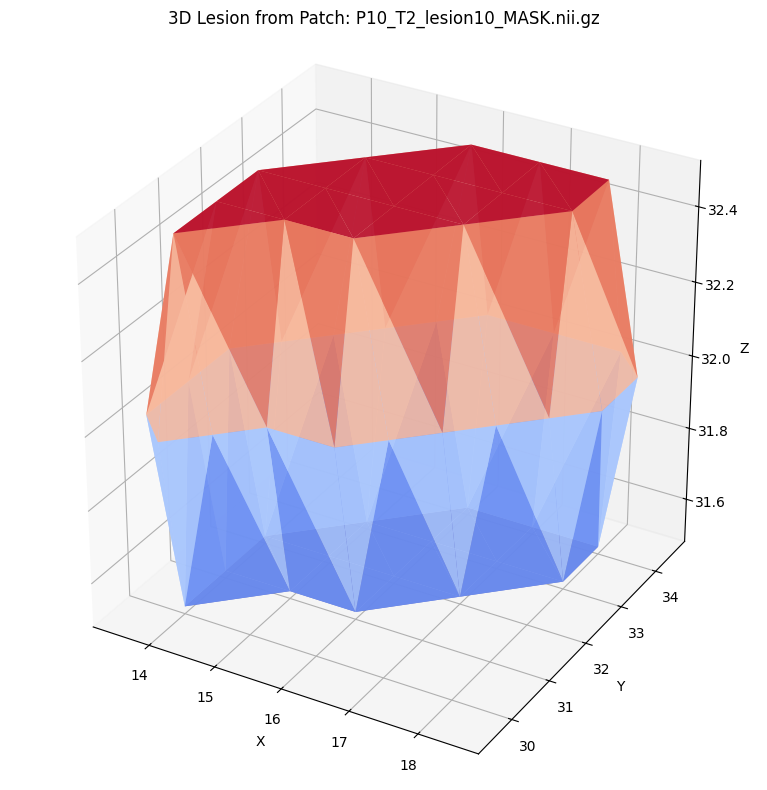

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, marching_cubes

mask_path = "/content/patches/T2/P10_T2_lesion10_MASK.nii.gz"

mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata()

labeled = label(mask_data > 0)
regions = regionprops(labeled)

largest_region = max(regions, key=lambda r: len(r.coords))
coords = largest_region.coords

lesion_mask = np.zeros_like(mask_data)
lesion_mask[tuple(coords.T)] = 1

verts, faces, normals, values = marching_cubes(lesion_mask, level=0.5)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(
    verts[:, 0], verts[:, 1], verts[:, 2],
    triangles=faces,
    cmap='coolwarm',
    lw=0.2,
    alpha=0.85
)

ax.set_title(f"3D Lesion from Patch: {mask_path.split('/')[-1]}", fontsize=12)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
plt.show()
